#Instalação de Pacotes

In [ ]:
!pip install -q yfinance

#Importar Pacotes 

In [ ]:

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

#Exportar para excell

In [ ]:
#piores.to_excel(r'C:\Users\Felipe\Desktop\export_dataframe.xlsx', index=False)

#Gráfico

#BACKTESTING CARE

#Dados complilados 

In [ ]:
#Dados do fundo
f=yf.download("CARE11.SA", start="2020-01-01", end="2023-04-18")
CARE11=f["Close"].pct_change(1)

return_serie = CARE11
return_serie.name = "return"

[*********************100%***********************]  1 of 1 completed


#Índices Importantes

In [ ]:
#sortino


# Cálculo do sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

Sortino: 2.748


In [ ]:
# CovariÂncia entre o mercado e o fundo
f1 = yf.download("BOVA11.SA", start="2020-01-01", end="2023-04-18")
BOVA11=f1["Close"].pct_change(1)


# Concatenar
val = pd.concat((return_serie, BOVA11), axis=1).dropna()

# Calcular Beta
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: 0.251


In [ ]:
# Cálculo do alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: 68.4


In [ ]:
def drawdown_function(serie):

  # Máximo dos retornos
  cum = serie.dropna().cumsum() + 1

  # Máximo de ganho do período (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # cálculo do drawdown
  drawdown = cum/running_max - 1
  return drawdown

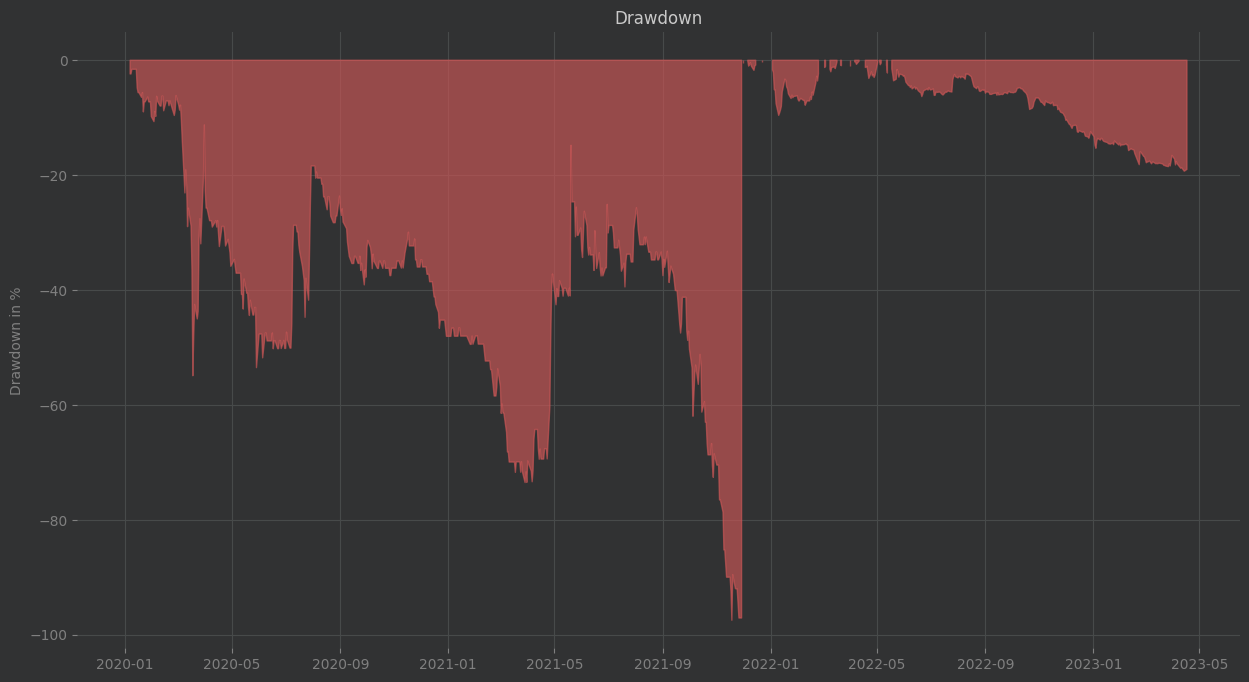

In [ ]:
#Cálculo do drawdown
drawdown = drawdown_function(return_serie)

# Tamanho da figura
plt.figure(figsize=(15,8))

# Plotagem do drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Título
plt.title("Drawdown")

# Eixo Y
plt.ylabel("Drawdown in %")

plt.show()

In [ ]:
#Função Completa

In [ ]:
def BackTest(serie, annualiazed_scalar=252):

  # Mercado
  sp500 = yf.download("BOVA11.SA")["Close"].pct_change(1)
  
  # Trocar o nome
  sp500.name = "SP500"

  # Concatenar os retornos com o mercado
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Cálculo do drawdown
  drawdown = drawdown_function(serie)*100
  
  # Computar o drawdown máximo
  max_drawdown = -np.min(drawdown)




  # Subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Subtítulo
  fig.suptitle("Backtesting", size=20)

  # Soma acumulada dos retornos
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500/BOVA11 - soma acumulada dos retornos 
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Legenda
  cum.legend(["CARE", "Mercado"])
  
  # Título individual
  cum.set_title("Retorno Acumulado", size=13)

  cum.set_ylabel("Retorno Acumulado %", size=11)

  # Colocar o drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Título
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plotar o gráfico
  plt.show()
  

  # Computar o sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Computar o beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Computar o alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir os índices
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


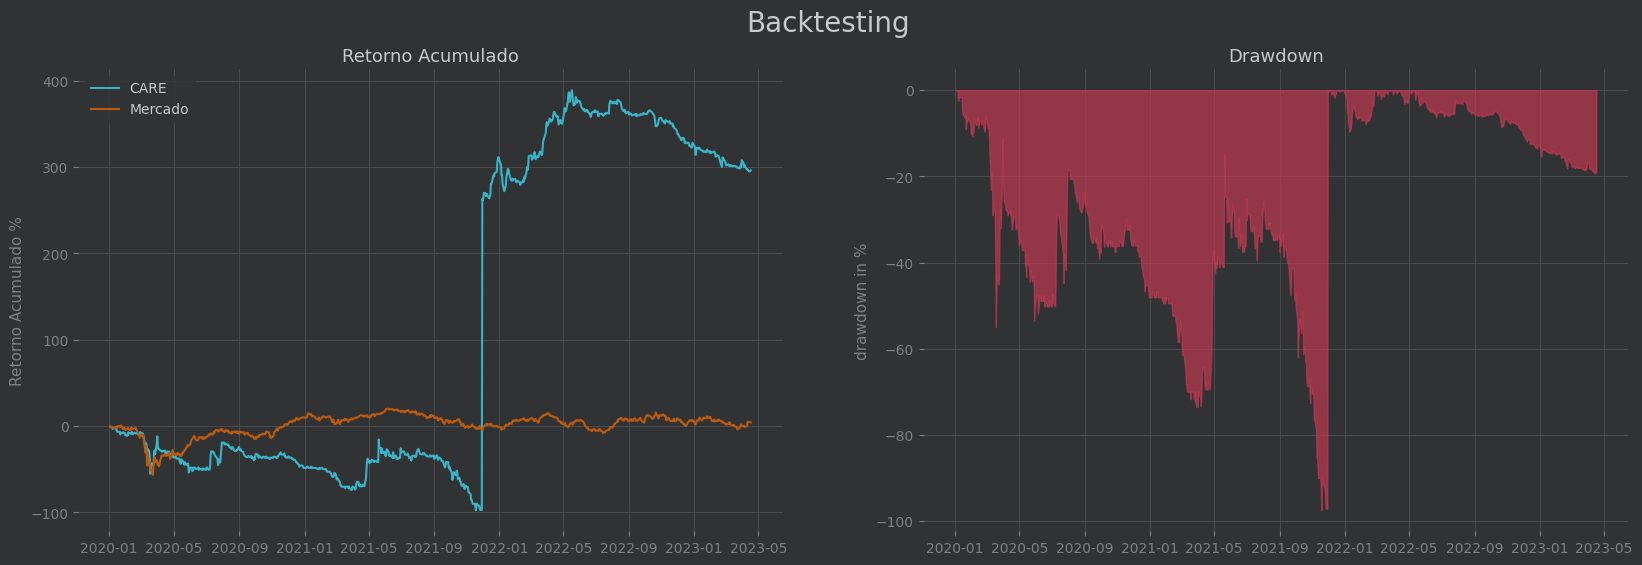

Sortino: 2.745
Beta: 0.251
Alpha: 68.375 %
MaxDrawdown: 97.453 %


In [ ]:
BackTest(return_serie, 252)

#Comparando com a SELIC e CDI

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True) 
  
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [ ]:
cdi = cdi_acumulado('2020-01-01', '2023-04-18') * 100
cdi

,valor
data,
2020-01-02,100.000000
2020-01-03,100.034181
2020-01-06,100.051276
2020-01-07,100.068374
2020-01-08,100.085474
...,...
2023-04-11,124.899452
2023-04-12,124.962886
2023-04-13,125.026352


In [ ]:
def selic_acumulada(data_inicio, data_fim):
  codigo_bcb = 4390
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  selic = pd.read_json(url)
  selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
  selic.set_index('data', inplace=True) 
  
  selic_acumulada = (1 + selic[data_inicio : data_fim] / 100).cumprod()
  selic_acumulada.iloc[0] = 1
  return selic_acumulada

In [ ]:
selic= selic_acumulada('2020-01-01', '2023-04-18') * 100
selic

,valor
data,
2020-01-01,100.000000
2020-02-01,100.671102
2020-03-01,101.013384
2020-04-01,101.296221
2020-05-01,101.539332
2020-06-01,101.752565
2020-07-01,101.945895
2020-08-01,102.109008
2020-09-01,102.272382


In [ ]:
cdi

,valor
data,
2020-01-02,100.000000
2020-01-03,100.034181
2020-01-06,100.051276
2020-01-07,100.068374
2020-01-08,100.085474
...,...
2023-04-11,124.899452
2023-04-12,124.962886
2023-04-13,125.026352


In [ ]:
selic

,valor
data,
2020-01-01,100.000000
2020-02-01,100.671102
2020-03-01,101.013384
2020-04-01,101.296221
2020-05-01,101.539332
2020-06-01,101.752565
2020-07-01,101.945895
2020-08-01,102.109008
2020-09-01,102.272382


#CARE

In [ ]:
f

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1.33,1.34,1.28,1.28,1.28,256896
2020-01-03,1.29,1.30,1.27,1.27,1.27,74936
2020-01-06,1.27,1.27,1.25,1.27,1.27,69426
2020-01-07,1.27,1.29,1.24,1.24,1.24,106796
2020-01-08,1.25,1.26,1.24,1.24,1.24,68051
...,...,...,...,...,...,...
2023-04-11,2.05,2.06,1.93,2.02,2.02,4765
2023-04-12,2.02,2.05,1.98,2.00,2.00,20244
2023-04-13,1.98,2.01,1.93,1.98,1.98,25835


#Calcular a rentabilidade do CARE

In [ ]:
CARE=(f / f.iloc[0])*100

In [ ]:
CARE

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2020-01-03,96.992475,97.014919,99.218751,99.218751,99.218751,29.169781
2020-01-06,95.488717,94.776116,97.656252,99.218751,99.218751,27.024944
2020-01-07,95.488717,96.268651,96.875003,96.875003,96.875003,41.571687
2020-01-08,93.984959,94.029848,96.875003,96.875003,96.875003,26.489708
...,...,...,...,...,...,...
2023-04-11,154.135330,153.731335,150.781249,157.812502,157.812502,1.854836
2023-04-12,151.879693,152.985067,154.687505,156.250003,156.250003,7.880232
2023-04-13,148.872177,149.999996,150.781249,154.687505,154.687505,10.056599


In [ ]:
CARE2=CARE['Adj Close']

In [ ]:
CARE2

Date
2020-01-02    100.000000
2020-01-03     99.218751
2020-01-06     99.218751
2020-01-07     96.875003
2020-01-08     96.875003
                 ...    
2023-04-11    157.812502
2023-04-12    156.250003
2023-04-13    154.687505
2023-04-14    153.125006
2023-04-17    155.468754
Name: Adj Close, Length: 818, dtype: float64

#Gráfico mais requintado (editável com "mommentum"): CARE vs Selic

In [ ]:
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import datetime as dt
import plotly.io as pio
pio.templates.default = "seaborn"

In [ ]:
trace0 = go.Scatter(x=CARE2.index, y=CARE2, name='Care11', line=dict(color='lime'))
trace1 = go.Scatter(x=selic.index, y=selic.valor, name='Selic', line=dict(color='red'))

fig1 = go.Figure([trace0, trace1])
fig1.update_layout(dict(
    title=dict({
        'text': "Care vs Selic",
        'x':0.0,
        'xanchor': 'center'}),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=3,
                     label='3m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='12m',
                     step='month',
                     stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date')))
fig1.show()